<a href="https://colab.research.google.com/github/saraswatiyangandul20/Analysis-of-Bank-Debit-Collection-and-Recovery-Strategies/blob/main/Which_Debts_Are_Worth_the_Bank's_Effort%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Which Debts Are Worth the Bank's Effort?

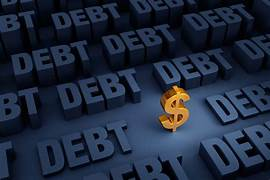

## 1. Regression discontinuity: banking recovery
<p>After a debt has been legally declared "uncollectable" by a bank, the account is considered to be "charged-off." But that doesn't mean the bank simply <strong><em>walks away</em></strong> from the debt. They still want to collect some of the money they are owed. The bank will score the account to assess the expected recovery amount, that is, the expected amount that the bank may be able to receive from the customer in the future (for a fixed time period such as one year). This amount is a function of the probability of the customer paying, the total debt, and other factors that impact the ability and willingness to pay.</p>
<p>The bank has implemented different recovery strategies at different thresholds (\$1000, \$2000, etc.) where the greater the expected recovery amount, the more effort the bank puts into contacting the customer. For low recovery amounts (Level 0), the bank just adds the customer's contact information to their automatic dialer and emailing system. For higher recovery strategies, the bank incurs more costs as they leverage human resources in more efforts to contact the customer and obtain payments. Each additional level of recovery strategy requires an additional \$50 per customer so that customers in the Recovery Strategy Level 1 cost the company \$50 more than those in Level 0. Customers in Level 2 cost \$50 more than those in Level 1, etc. </p>
<p><strong>The big question</strong>: does the extra amount that is recovered at the higher strategy level exceed the extra \$50 in costs? In other words, was there a jump (also called a "discontinuity") of more than \$50 in the amount recovered at the higher strategy level? We'll find out in this notebook.</p>
<p>![Regression discontinuity graph]
<p>First, we'll load the banking dataset and look at the first few rows of data. This puts us in a good position to understand the dataset itself and begin thinking about how to analyze the data.</p>

In [22]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import pandas as pd
# reading data file
dir_path = '/content/bank_data.csv'
df = pd.read_csv(dir_path)

In [24]:
df.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


In [25]:
df.tail()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
1877,361,9785,15388.195990,Level 4 Recovery,65,Female
1878,196,9857,9709.909257,Level 4 Recovery,68,Female
1879,313,9859,30209.181790,Level 4 Recovery,58,Female
1880,1781,9920,20386.232190,Level 4 Recovery,67,Female
1881,522,9964,16706.305920,Level 4 Recovery,53,Male


In [26]:
df.shape

(1882, 6)

In [27]:
df.nunique()

id                          1882
expected_recovery_amount    1529
actual_recovery_amount      1882
recovery_strategy              5
age                           67
sex                            2
dtype: int64

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882 entries, 0 to 1881
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1882 non-null   int64  
 1   expected_recovery_amount  1882 non-null   int64  
 2   actual_recovery_amount    1882 non-null   float64
 3   recovery_strategy         1882 non-null   object 
 4   age                       1882 non-null   int64  
 5   sex                       1882 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 88.3+ KB


In [29]:
df.describe()

,id,expected_recovery_amount,actual_recovery_amount,age
count,1882.000000,1882.000000,1882.000000,1882.000000
mean,1035.596174,2759.967588,4000.967837,39.650372
std,591.458429,2019.826565,4576.506350,15.453072
min,6.000000,194.000000,200.425000,18.000000
25%,534.250000,1261.250000,1045.190300,28.000000
50%,1029.500000,2062.000000,2115.446373,35.000000
75%,1551.750000,3569.500000,5417.237207,50.000000
max,2056.000000,9964.000000,34398.479710,84.000000


In [30]:
df.isna().sum()

id                          0
expected_recovery_amount    0
actual_recovery_amount      0
recovery_strategy           0
age                         0
sex                         0
dtype: int64

## 2. Graphical exploratory data analysis
<p>The bank has implemented different recovery strategies at different thresholds (\$1000, \$2000, \$3000 and \$5000) where the greater the Expected Recovery Amount, the more effort the bank puts into contacting the customer. Zeroing in on the first transition (between Level 0 and Level 1) means we are focused on the population with Expected Recovery Amounts between \$0 and \$2000 where the transition between Levels occurred at \$1000. We know that the customers in Level 1 (expected recovery amounts between \$1001 and \$2000) received more attention from the bank and, by definition, they had higher Expected Recovery Amounts than the customers in Level 0 (between \$1 and \$1000).</p>
<p>Here's a quick summary of the Levels and thresholds again:</p>
<ul>
<li>Level 0: Expected recovery amounts &gt;\$0 and &lt;=\$1000</li>
<li>Level 1: Expected recovery amounts &gt;\$1000 and &lt;=\$2000</li>
<li>The threshold of \$1000 separates Level 0 from Level 1</li>
</ul>
<p>A key question is whether there are other factors besides Expected Recovery Amount that also varied systematically across the \$1000 threshold. For example, does the customer age show a jump (discontinuity) at the \$1000 threshold or does that age vary smoothly? We can examine this by first making a scatter plot of the age as a function of Expected Recovery Amount for a small window of Expected Recovery Amount, \$0 to \$2000. This range covers Levels 0 and 1.</p>

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

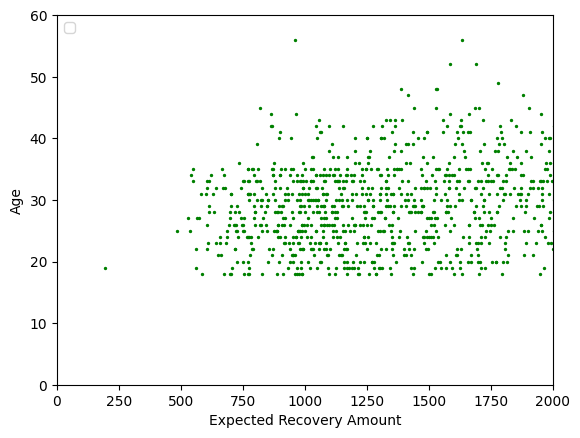

In [32]:
# Scatter plot of Age vs. Expected Recovery Amount
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(x=df['expected_recovery_amount'], y=df['age'], c="g", s=2)
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Age')
plt.legend(loc=2)
plt.show()

## 3. Statistical test:  age vs. expected recovery amount
<p>We want to convince ourselves that variables such as age and sex are similar above and below the \$1000 Expected Recovery Amount threshold. This is important because we want to be able to conclude that differences in the actual recovery amount are due to the higher Recovery Strategy and not due to some other difference like age or sex.</p>
<p>The scatter plot of age versus Expected Recovery Amount did not show an obvious jump around \$1000.  We will be more confident in our conclusions if we do statistical analysis examining the average age of the customers just above and just below the threshold. We can start by exploring the range from \$900 to \$1100.</p>
<p>For determining if there is a difference in the ages just above and just below the threshold, we will use the Kruskal-Wallis test which is a statistical test that makes no distributional assumptions.</p>

In [33]:
# Compute average age just below and above the threshold
r_900_1100 = df.loc[(df['expected_recovery_amount']<1100) &
                      (df['expected_recovery_amount']>=900)]
by_recovery_strategy = r_900_1100.groupby(['recovery_strategy'])

In [34]:
Level_0_age = r_900_1100.loc[df['recovery_strategy'] == "Level 0 Recovery"]['age']
Level_1_age = r_900_1100.loc[df['recovery_strategy'] == "Level 1 Recovery"]['age']

# Perform a two-sample t-test
t_stat, p_value = stats.ttest_ind(Level_0_age, Level_1_age)

# Print the results
print(f"t-statistic: {t_stat}")
print(f"P-value: {p_value}")

t-statistic: -1.6888055955231507
P-value: 0.09297868115283911


In [35]:
by_recovery_strategy['age'].describe().unstack()

       recovery_strategy
count  Level 0 Recovery     89.000000
       Level 1 Recovery     94.000000
mean   Level 0 Recovery     27.224719
       Level 1 Recovery     28.755319
std    Level 0 Recovery      6.399135
       Level 1 Recovery      5.859807
min    Level 0 Recovery     18.000000
       Level 1 Recovery     18.000000
25%    Level 0 Recovery     23.000000
       Level 1 Recovery     24.000000
50%    Level 0 Recovery     26.000000
       Level 1 Recovery     29.000000
75%    Level 0 Recovery     31.000000
       Level 1 Recovery     33.000000
max    Level 0 Recovery     56.000000
       Level 1 Recovery     43.000000
dtype: float64

## 4. Statistical test:  sex vs. expected recovery amount
<p>We were able to convince ourselves that there is no major jump in the average customer age just above and just
below the \$1000 threshold by doing a statistical test as well as exploring it graphically with a scatter plot.  </p>
<p>We want to also test that the percentage of customers that are male does not jump as well across the \$1000 threshold. We can start by exploring the range of \$900 to \$1100 and later adjust this range.</p>
<p>We can examine this question statistically by developing cross-tabs as well as doing chi-square tests of the percentage of customers that are male vs. female.</p>

In [36]:
crosstab = pd.crosstab(df.loc[(df['expected_recovery_amount']<1100) &
                              (df['expected_recovery_amount']>=900)]['recovery_strategy'],
                       df['sex'])
print(crosstab)

# Chi-square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)

print(p_val)

sex                Female  Male
recovery_strategy              
Level 0 Recovery       32    57
Level 1 Recovery       39    55
0.5377947810444592


In [37]:
# Chi-square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print(p_val)

0.5377947810444592


##4.Exploratory graphical analysis: recovery amount


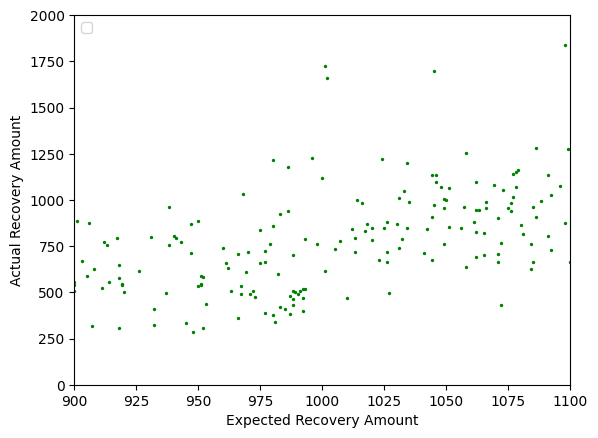

In [38]:
# Scatter plot of Actual Recovery Amount vs. Expected Recovery Amount
plt.scatter(x=df['expected_recovery_amount'], y=df['actual_recovery_amount'], c="g", s=2)
plt.xlim(900, 1100)
plt.ylim(0, 2000)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Actual Recovery Amount")
plt.legend(loc=2)
plt.show()

## 6. Statistical analysis:  recovery amount
<p>Just as we did with age, we can perform statistical tests to see if the actual recovery amount has a discontinuity above the \$1000 threshold. We are going to do this for two different windows of the expected recovery amount \$900 to \$1100 and for a narrow range of \$950 to \$1050 to see if our results are consistent.</p>
<p>Again, the statistical test we will use is the Kruskal-Wallis test, a test that makes no assumptions about the distribution of the actual recovery amount.</p>
<p>We will first compute the average actual recovery amount for those customers just below and just above the threshold using a range from \$900 to \$1100.  Then we will perform a Kruskal-Wallis test to see if the actual recovery amounts are different just above and just below the threshold.  Once we do that, we will repeat these steps for a smaller window of \$950 to \$1050.</p>

In [39]:
# Compute average actual recovery amount just below and above the threshold
by_recovery_strategy['actual_recovery_amount'].describe().unstack()

# Perform Kruskal-Wallis test
Level_0_actual = r_900_1100.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = r_900_1100.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
print(stats.kruskal(Level_0_actual, Level_1_actual) )

# Repeat for a smaller range of $950 to $1050
r_950_1050 = df.loc[(df['expected_recovery_amount']<1050) &
                      (df['expected_recovery_amount']>=950)]
Level_0_actual = r_950_1050.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = r_950_1050.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
print(stats.kruskal(Level_0_actual, Level_1_actual))

KruskalResult(statistic=65.37966302528878, pvalue=6.177308752803109e-16)
KruskalResult(statistic=30.246000000000038, pvalue=3.80575314300276e-08)


## 7. Regression modeling: no threshold
<p>We now want to take a regression-based approach to estimate the impact of the program at the \$1000 threshold using the data that is just above and just below the threshold. In order to do that, we will build two models.  The first model does not have a threshold while the second model will include a threshold.</p>
<p>The first model predicts the actual recovery amount (outcome or dependent variable) as a function of the expected recovery amount (input or independent variable). We expect that there will be a strong positive relationship between these two variables.  </p>
<p>We will examine the adjusted R-squared to see the percent of variance that is explained by the model.  In this model, we are not trying to represent the threshold but simply trying to see how the variable used for assigning the customers (expected recovery amount) relates to the outcome variable (actual recovery amount).</p>

In [40]:
import statsmodels.api as sm

# Define X and y
X = r_900_1100['expected_recovery_amount']
y = r_900_1100['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the model summary statistics
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Sun, 08 Oct 2023   Prob (F-statistic):           1.56e-13
Time:                            13:39:06   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

## 8. Regression modeling: adding true threshold
<p>From the first model, we see that the regression coefficient is statistically significant for the expected recovery amount and the adjusted R-squared value was about 0.26. As we saw from the graph, on average the actual recovery amount increases as the expected recovery amount increases. We could add polynomial terms of expected recovery amount (such as the squared value of expected recovery amount) to the model but, for the purposes of this practice, let's stick with using just the linear term.</p>
<p>The second model adds an indicator of the true threshold to the model. If there was no impact of the higher recovery strategy on the actual recovery amount, then we would expect that the relationship between the expected recovery amount and the actual recovery amount would be continuous.     </p>
<p>In this case, we know the true threshold is at \$1000.  </p>
<p>We will create an indicator variable (either a 0 or a 1) that represents whether or not the expected recovery amount was greater than \$1000. When we add the true threshold to the model, the regression coefficient for the true threshold represents the additional amount recovered due to the higher recovery strategy.  That is to say, the regression coefficient for the true threshold measures the size of the discontinuity for customers just above and just below the threshold.</p>
<p>If the higher recovery strategy did help recovery more money, then the regression coefficient of the true threshold will be greater than zero.  If the higher recovery strategy did not help recover more money than the regression coefficient will not be statistically significant.</p>

In [41]:
# Create indicator (0 or 1) for expected recovery amount >= $1000
import numpy as np
df['indicator_1000'] = np.where(df['expected_recovery_amount']<1000, 0, 1)
r_900_1100 = df.loc[(df['expected_recovery_amount']<1100) &
                      (df['expected_recovery_amount']>=900)]

# Define X and y
X = r_900_1100[['expected_recovery_amount','indicator_1000']]
y = r_900_1100['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.307
Method:                     Least Squares   F-statistic:                     41.22
Date:                    Sun, 08 Oct 2023   Prob (F-statistic):           1.83e-15
Time:                            13:39:06   Log-Likelihood:                -1272.0
No. Observations:                     183   AIC:                             2550.
Df Residuals:                         180   BIC:                             2560.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

## 9. Regression modeling: adjusting the window
<p>The regression coefficient for the true threshold was statistically significant with an estimated impact of around \$278 and a 95 percent confidence interval of \$132 to \$424.  This is much larger than the incremental cost of running the higher recovery strategy which was \$50 per customer. At this point, we are feeling reasonably confident that the higher recovery strategy is worth the additional costs of the program for customers just above and just below the threshold.  </p>
<p>Before showing this to our managers, we want to convince ourselves that this result wasn't due just to us choosing a window of \$900 to \$1100 for the expected recovery amount. If the higher recovery strategy really had an impact of an extra few hundred dollars, then we should see a similar regression coefficient if we choose a slightly bigger or a slightly smaller window for the expected recovery amount.  Let's repeat this analysis for the window of expected recovery amount from \$950 to \$1050 to see if we get similar results.</p>
<p>The answer? Whether we use a wide window (\$900 to \$1100) or a narrower window (\$950 to \$1050), the incremental recovery amount at the higher recovery strategy is much greater than the \$50 per customer it costs for the higher recovery strategy.  So we can say that the higher recovery strategy is worth the extra \$50 per customer that the bank is spending.</p>

In [42]:
# Redefine era_950_1050 so the indicator variable is included
r_950_1050 = df.loc[(df['expected_recovery_amount']<1050) &
                      (df['expected_recovery_amount']>=950)]

# Define X and y
X = r_950_1050[['expected_recovery_amount','indicator_1000']]
y = r_950_1050['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.283
Model:                                OLS   Adj. R-squared:                  0.269
Method:                     Least Squares   F-statistic:                     18.99
Date:                    Sun, 08 Oct 2023   Prob (F-statistic):           1.12e-07
Time:                            13:39:06   Log-Likelihood:                -692.92
No. Observations:                      99   AIC:                             1392.
Df Residuals:                          96   BIC:                             1400.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -279.5243   1840.707     -0.152      0.880   -3933.298    3374.250
expected_recovery_amount     0.9189      1.886      0.487      0.627      -2.825       4.663
indicator_1000             286.5337    111.352      2.573      0.012      65.502     507.566
==============================================================================
Omnibus:                       39.302   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.258
Skew:                           1.564   Prob(JB):                     1.37e-18
Kurtosis:                       6.186   Cond. No.                     6.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""